In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import mapclassify
import geopandas as gpd
import pandas as pd
from _bootstrap import *
from community_detection import (
    GraphConstructor,
    CommunityDetector,
    PolygonDissolver)
from paths import get_paths
input_dir, output_dir, plots_dir = get_paths()

In [7]:
# Set target pop
target_pop = 1000

matrix = pd.read_parquet(output_dir / "matrix.parquet")

# Select matrix
matrix = matrix.loc[matrix["target_pop"]==target_pop].copy()

tracts = gpd.read_file(output_dir / "tracts.gpkg", layer=f"tracts_{target_pop}")
tracts["TractID"] = tracts["TractID"].astype(str)

matrix["TractID_1"] = matrix["TractID_1"].astype(str)
matrix["TractID_2"] = matrix["TractID_2"].astype(str)

gc = GraphConstructor(matrix, weights_col="combined_score")
gc.build_graph()
G = gc.get_graph()

In [8]:
# Execute Infomap with spatial enforcement
cd = CommunityDetector(G, tracts, trials=30)
result, score, time = cd.run_infomap(return_codelength=True, preferred_modules=39, measure_time=True,
                                     enforce_spatial=True, strategy="strongest_connection", verbose=False)

df = pd.DataFrame(result.items(), columns=["TractID", "community"])

li = cd.compute_localisation_index(result, matrix, weight_col="n_visits")
li.LI.describe()

count    38.000000
mean      0.685555
std       0.116962
min       0.465089
25%       0.611273
50%       0.699773
75%       0.762750
max       0.937851
Name: LI, dtype: float64

In [9]:
# Create the PCSAs
tracts["TractID"] = tracts["TractID"].astype(str)
polygon_dissolver = PolygonDissolver(tracts)
pcsa = polygon_dissolver.process_community_outcomes(communities=df, verbose=False)

# Add Localisation Index with flow values
pcsa = pcsa.merge(li, on="community", how="left")
pcsa.head()

,commune_id,commune,community,pop,pop_high,pop_middle,pop_low,geometry,D_c,D_cc,LI
0,13201,PUENTE ALTO,1,66456,3985,30250,32221,"POLYGON ((351391.601 6279738.055, 351396.797 6...",238618,168569,0.706439
1,13201,PUENTE ALTO,2,85245,8806,48157,28282,"POLYGON ((354361.645 6281668.491, 354361.539 6...",260148,161248,0.619832
2,13201,PUENTE ALTO,3,52012,1497,18519,31996,"POLYGON ((352389.172 6276812.313, 352383.438 6...",272555,219703,0.806087
3,13110,LA FLORIDA,4,44188,999,16408,26781,"POLYGON ((350352.737 6284165.231, 350352.065 6...",215609,153086,0.710017
4,13201,PUENTE ALTO,5,50439,2051,22913,25475,"POLYGON ((350953.821 6281577.598, 350949.437 6...",227421,151612,0.666658


c:\Users\fport\miniconda3\envs\dissertation\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


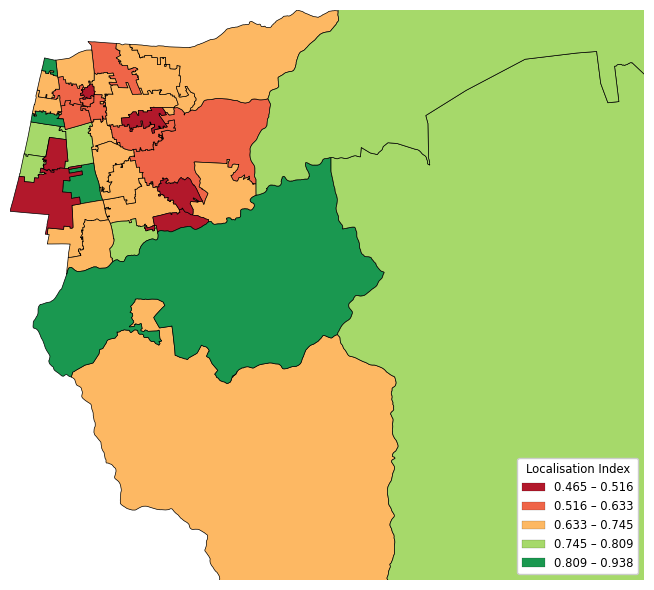

In [10]:
#Classify using Natural Breaks (Jenks)
nb = mapclassify.NaturalBreaks(y=pcsa["LI"], k=5)
pcsa["LI_class"] = nb.yb  # class indices (0 to 4)

# Create numeric range labels for legend
bin_labels = [f"{round(b, 3)} – {round(nb.bins[i], 3)}" for i, b in enumerate([pcsa["LI"].min()] + list(nb.bins[:-1]))]

# Assign a color to each bin
color_list = ['#b2182b', '#ef6548', '#fdb863', '#a6d96a', '#1a9850']
color_dict = {i: color_list[i] for i in range(5)}

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
pcsa.plot(
    color=pcsa["LI_class"].map(color_dict),
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

urban_comms = ['PUENTE ALTO', 'SAN RAMÓN', 'LA FLORIDA', 'LA PINTANA', 'LA GRANJA']
urban_pcsas = pcsa.loc[pcsa.commune.isin(urban_comms)]
minx, miny, maxx, maxy = urban_pcsas.total_bounds
ax.set_xlim(minx, maxx + 20000)
ax.set_ylim(miny - 20000, maxy)

ax.axis('off')

legend_handles = [
    Patch(facecolor=color_dict[i], edgecolor='black', linewidth=0.1, label=bin_labels[i])
    for i in range(5)
]
ax.legend(
    handles=legend_handles,
    title="Localisation Index",
    loc='lower right',
    fontsize='small',
    title_fontsize='small',
    framealpha=1
)

plt.tight_layout()
plt.savefig(plots_dir / "pcsa_LI.png", dpi=300, bbox_inches='tight')
plt.show()